In [1]:
import polars as pl
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import numpy as np
import logging
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(seed)
print(tf.__version__)

2024-06-15 22:31:48.522398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 22:31:48.588281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 22:31:49.629379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq, build_sequences_seq_iterator, N_CATEGORY, N_SENTIMENT_LABEL, N_SUBCATEGORY, N_TOPICS, N_HOUR_GROUP, N_WEEKDAY
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder

history = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

history_seq = build_history_seq(history, articles)

columns = [
    'device_type', 'read_time', 'scroll_percentage', 'is_sso_user', 'gender', 'age', 'is_subscriber', 'postcode',
    'trendiness_score_1d', 'trendiness_score_3d', 'weekday', 'hour', 'trendiness_score_1d/3d', 
    'normalized_trendiness_score_overall', 'premium', 'category', 'sentiment_score', 'sentiment_label', 
    'num_images', 'title_len', 'subtitle_len', 'body_len', 'num_topics', 'total_pageviews', 'total_inviews',
    'total_read_time', 'total_pageviews/inviews', 'article_type', 'article_delay_days', 'article_delay_hours', 
    'Entity_LOC_Present', 'Entity_PROD_Present', 'Entity_ORG_Present', 'Entity_MISC_Present',
    'Entity_EVENT_Present', 'Entity_PER_Present', 'mean_user_trendiness_score', 'mean_topics_trendiness_score',
    'is_inside_window_0', 'is_inside_window_1', 'is_inside_window_2', 'is_inside_window_3', 'window_category_score',
    'window_topics_score', 'trendiness_score_category', 'endorsement_10h', 'normalized_endorsement_10h',
    'endorsement_10h_diff_rolling', 'endorsement_macd', 'endorsement_quantile_norm_10h',
    'normalized_endorsement_10h_rolling_max_ratio', 'endorsement_20h_articleuser', 'normalized_endorsement_articleuser_20h',
    'endorsement_20h_articleuser_diff_rolling', 'endorsement_articleuser_macd', 'endorsement_articleuser_quantile_norm_20h',
    'normalized_endorsement_articleuser_20h_rolling_max_ratio', 'last_session_duration', 'mean_prev_sessions_duration',
    'last_session_time_hour_diff', 'is_new_article', 'is_already_seen_article', 'yesterday_category_daily_pct',
    'target', 'user_id'
]
behaviors = pl.scan_parquet('/home/ubuntu/dset_complete/subsample/train_ds.parquet').select(columns).collect()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'postcode', 'weekday', 'premium', 'category',
                       'sentiment_label', 'Entity_LOC_Present', 'Entity_PROD_Present', 'Entity_ORG_Present', 'Entity_MISC_Present',
                       'Entity_EVENT_Present', 'Entity_PER_Present', 'article_type']
numerical_columns = [c for c in columns if c not in categorical_columns + ['target', 'user_id', 'impression_id', 'article']]

behaviors_pandas = behaviors.to_pandas()

xformer = PowerTransformer()
behaviors_pandas[numerical_columns] = behaviors_pandas[numerical_columns].replace([-np.inf, np.inf], np.nan).fillna(0)
behaviors_pandas[numerical_columns] = xformer.fit_transform(behaviors_pandas[numerical_columns]).astype(np.float32)

encoder = OrdinalEncoder()
behaviors_pandas[categorical_columns] = encoder.fit_transform(behaviors_pandas[categorical_columns]).astype(np.int16)
behaviors = behaviors.select(['target', 'user_id']).hstack(pl.from_pandas(behaviors_pandas[numerical_columns + categorical_columns]))

Memory usage of dataframe is 35.03 MB
Memory usage after optimization is: 34.44 MB
Decreased by 1.7%


In [3]:
vocabulary_sizes = {
    feature: len(encoder.categories_[i]) for i, feature in enumerate(categorical_columns)
}

In [4]:
from polimi.utils.tf_models.utils.build_sequences import build_sequences_cls_iterator

window = 20
training_dataset = tf.data.Dataset.from_generator(
    lambda : build_sequences_cls_iterator(history_seq, behaviors, window=window, numerical_columns=numerical_columns,
                                          categorical_columns=categorical_columns),
    output_signature=(
        {
            'numerical_columns': tf.TensorSpec(shape=(len(numerical_columns),), dtype=tf.float32), # behaviors numerical columns
            **{c: tf.TensorSpec(shape=(), dtype=tf.int16) for c in categorical_columns}, # behaviors categorical columns
            'input_topics': tf.TensorSpec(shape=(window,N_TOPICS+1), dtype=tf.int32), # history topics sequence
            'input_category': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history category sequence
            'input_subcategory': tf.TensorSpec(shape=(window, N_SUBCATEGORY+1), dtype=tf.int32), # history subcategory sequence
            'input_weekday': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history weekday sequence
            'input_hour_group': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history hour_group sequence
            'input_sentiment_label': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history sentiment_label sequence
            'input_numerical': tf.TensorSpec(shape=(window, 3), dtype=tf.float32), # history (premium, read_time, scroll_percentage) sequence
        },
        tf.TensorSpec(shape=(), dtype=tf.float32), # target
    )
).shuffle(buffer_size=1024).batch(64)

In [5]:
from polimi.utils.tf_models import TemporalHistorySequenceModel, TemporalHistoryClassificationModel

model = TemporalHistoryClassificationModel(
    categorical_features=categorical_columns,
    numerical_features=numerical_columns,
    vocabulary_sizes=vocabulary_sizes,
    seq_embedding_dims={
        # adding, for the moment, one dim more to cover missings in non one-hot vectors
        'input_topics': (N_TOPICS + 1, 10, True),
        'input_subcategory': (N_SUBCATEGORY + 1, 10, True),
        'input_category': (N_CATEGORY + 1, 10, False),
        'input_weekday': (N_WEEKDAY, 3, False),
        'input_hour_group': (N_HOUR_GROUP, 3, False),
        'input_sentiment_label': (N_SENTIMENT_LABEL + 1, 2, False)
    },
    seq_numerical_features=['scroll_percentage', 'read_time', 'premium'],
    n_recurrent_layers=1,
    recurrent_embedding_dim=64,
    l1_lambda=1e-4,
    l2_lambda=1e-4,
    dense_n_layers=1,
    dense_start_units=128,
)

In [6]:
model._build()

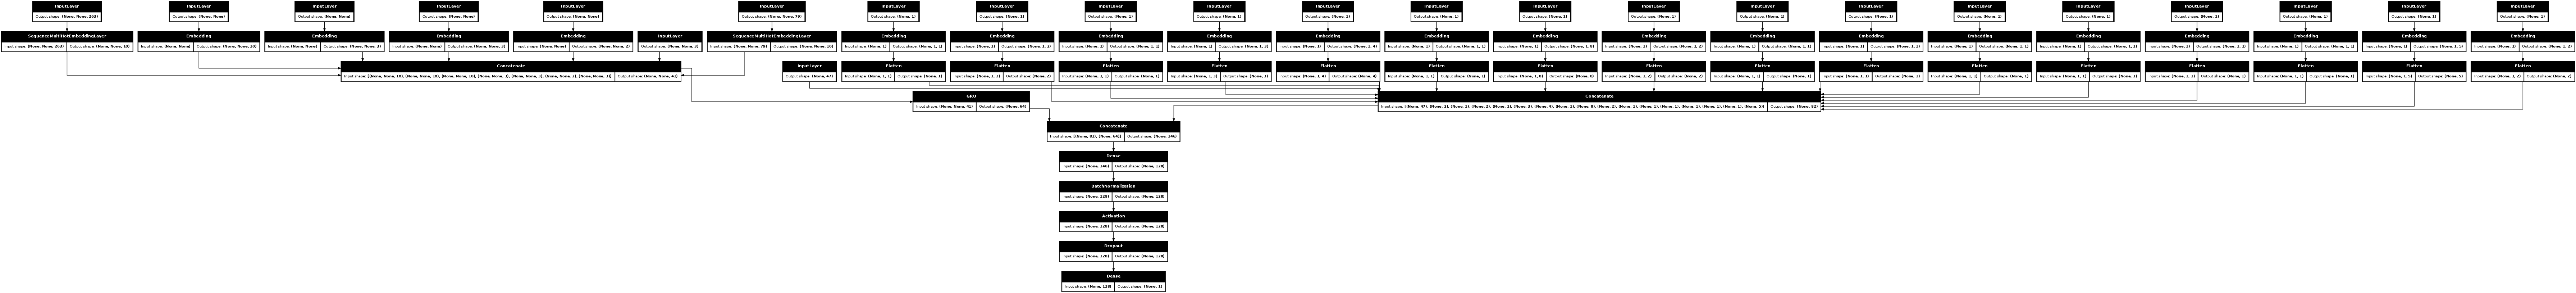

In [7]:
model.plot()

In [8]:
model.fit(
    train_dataset=training_dataset,
    batch_size=64,
    epochs=10,
    loss=tfk.losses.BinaryCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4)
)

Epoch 1/10


   8103/Unknown 1437s 176ms/step - loss: 0.7425

KeyboardInterrupt: 